# 📡 Имитационное моделирование RFID системы в зависимости от параметра `Q` и количества меток в зоне чтения

В данном блокноте проводится имитацинное моделирование RFID системы для изучения зависимости вероятности чтения банка памяти `USER` от параметра, количества меток в зоне чтения, количества коллизий. Также изучается работа команды QueryAdjust и алгоритма коррекции `Q`

### Импорт необходимых модулей

In [1]:
import numpy as np

from pysim.experiments.utility.rfid_helper import(
    calculate_probs, generation_interval, plot_probs
)
from pysim.models.rfid.params import default_params, inner_params, KMPH_TO_MPS_MUL
from utility.channel_helper import(
    find_zones, get_tag_rx
)

In [2]:
IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "results/result_jsons/rfid/multiple_tag/"

### ⚙️ Общие параметры для разных кривых

In [3]:
q_variable = np.arange(0, 16, 1)
coding_params = [
    # {'encoding': 'FM0', 'tari': 6.25},
    # {'encoding': 'FM0', 'tari': 18.75},
    # {'encoding': 'M2', 'tari': 12.5},
    # {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

q_params_list = []
for coding_params_item in coding_params:
    q_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
         # 'num_tags': default_params.num_tags,
        'num_tags': 2,
        'speed': 25,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
    })

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае без коллизий и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

Как хорошо видно из результатов, при небольших значениях `Q` разницы в величине вероятности почти нет. Начиная с Q = 7 вероятность чтения начинает стремительно уменьшаться из-за того, что раунд заполняется пустыми слотами и становится слишком длинным. В результате этого метка успевает принять участие в меньшем количестве раундов инвентаризации и вероятность снижается.

### 💾 Получение результатов

In [4]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [5]:
q_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q.json"
)
# Моделирование на M3 Pro с 'num_tags': 200:
# Моделирование по переменной q: 100%|██████████| 5/5 [02:37<00:00, 31.41s/it]

### 🖼️ Построение графика

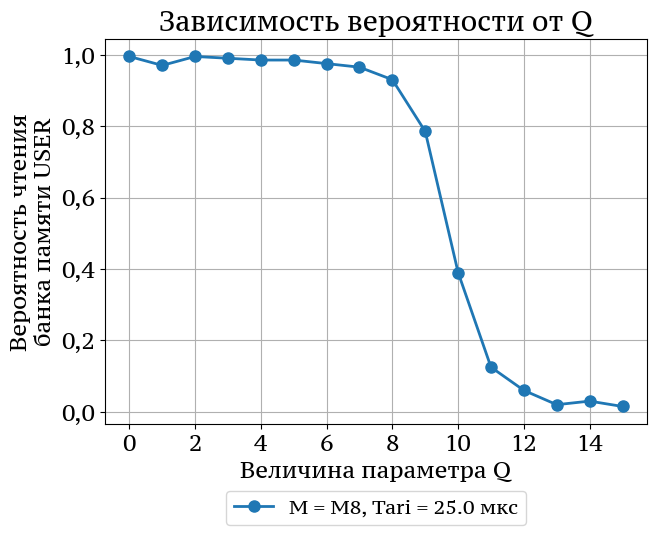

In [6]:
plot_probs(
    results_list=[q_result],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость вероятности от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Q probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае **с коллизиями** и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

In [7]:
def estimate_generation_interval(tags_amount: int, reading_zone: float, speed: float) -> float:
    """
    Пересчитывает желаемое количество меток в зоне чтения в требуемый интервал генерации.

    Args:
        tags_amount: желаемое количество меток в зоне
        reading_zone: суммарная длина зон, где метка включена (в метрах)
        speed: скорость движения считывателя в км/ч

    Returns:
        Интервал генерации в секундах (временной промежуток между метками)
    """
    # Преобразуем скорость в м/с
    speed_mps = speed * KMPH_TO_MPS_MUL

    return reading_zone / (tags_amount * speed_mps)

In [8]:
MINIMUM_DISTANCE = -15
MAXIMUM_DISTANCE = 15
GRID_STEP = 200
TAG_SENSITIVITY = inner_params.energy_params.tag_sensitivity 

# Вычисление длины зоны активности меток
ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)
tag_accepted_power = [get_tag_rx(x, speed=0, t=0) for x in ox_axis]
tag_on_intervals = find_zones(ox_axis, tag_accepted_power, TAG_SENSITIVITY, use_upper=True)
reading_zone = sum(end - start for start, end in tag_on_intervals)

# Вычисление расстояния между генерируемыми метками
# gen_interval_fn, gen_interval_args = additional_params["generation_interval"]
# tag_distance = gen_interval_fn(gen_interval_args) * q_params_list[0]["speed"] * KMPH_TO_MPS_MUL

# # Вычисление плотности меток в зоне активности
# tag_amount = reading_zone / tag_distance

In [9]:
# time1 = estimate_generation_interval(10, reading_zone, q_params_list[0]["speed"])
time2 = estimate_generation_interval(5, reading_zone, q_params_list[0]["speed"])
time3 = estimate_generation_interval(25, reading_zone, q_params_list[0]["speed"])
time4 = estimate_generation_interval(100, reading_zone, q_params_list[0]["speed"])

In [10]:
tag_period_params = [
    # {"generation_interval": (generation_interval, time1)},
    {"generation_interval": (generation_interval, time2)},
    {"generation_interval": (generation_interval, time3)},
    {"generation_interval": (generation_interval, time4)}
]

# additional_params = {"generation_interval": (generation_interval, 0.095)}

In [11]:
q_variable = np.arange(0, 16, 1)

params_list = [
    {
        'tari': default_params.tari,
        'encoding':  default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': 31,
        'num_tags': 350,
        'speed': 25,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': False,
    }
]

In [12]:
labels = ["5 меток", "25 меток", "100 меток"]

In [13]:
results_list = []

for label, tag_params in zip(labels, tag_period_params):
    results = calculate_probs(
        variable="q",
        variable_values=q_variable,
        params_list=params_list,
        key_fn=lambda _: "",  # пустая заглушка, не используется
        manual_key=label,
        additional_params = tag_params,
        use_json=False,
        save_results=True,
        json_directory=JSON_DIRECTORY,
        file_name="q_collision_new.json"
    )
    results_list.append(results)

Моделирование по переменной q: 100%|██████████| 1/1 [00:35<00:00, 35.81s/it]


Collisions: {'5 меток': [463.0657142857143, 72.64571428571429, 11.882857142857143, 4.64, 2.0914285714285716, 1.0514285714285714, 0.4, 0.18285714285714286, 0.11428571428571428, 0.022857142857142857, 0.005714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0]}
Rounds: {'5 меток': [463.1771428571429, 79.00857142857143, 19.908571428571427, 12.685714285714285, 9.857142857142858, 8.9, 7.4714285714285715, 6.28, 4.857142857142857, 3.32, 2.0314285714285716, 1.3657142857142857, 0.6342857142857142, 0.5485714285714286, 0.5485714285714286, 0.5485714285714286]}


Моделирование по переменной q: 100%|██████████| 1/1 [00:33<00:00, 33.09s/it]


Collisions: {'25 меток': [462.3514285714286, 264.2085714285714, 134.58285714285714, 22.16857142857143, 3.4914285714285715, 1.1314285714285715, 0.5742857142857143, 0.21428571428571427, 0.06285714285714286, 0.02857142857142857, 0.022857142857142857, 0.011428571428571429, 0.0, 0.0, 0.0, 0.0]}
Rounds: {'25 меток': [462.46, 264.75714285714287, 135.45714285714286, 23.985714285714284, 5.485714285714286, 3.354285714285714, 2.7514285714285713, 2.3514285714285714, 2.0142857142857142, 1.737142857142857, 1.5914285714285714, 1.217142857142857, 0.5657142857142857, 0.5657142857142857, 0.5657142857142857, 0.5657142857142857]}


Моделирование по переменной q: 100%|██████████| 1/1 [00:34<00:00, 34.47s/it]

Collisions: {'100 меток': [431.27714285714285, 262.89714285714285, 140.7, 71.36285714285714, 29.731428571428573, 4.545714285714285, 1.0, 0.34285714285714286, 0.13142857142857142, 0.05714285714285714, 0.022857142857142857, 0.005714285714285714, 0.0, 0.0, 0.0, 0.0]}
Rounds: {'100 меток': [431.3285714285714, 263.42571428571426, 141.35714285714286, 72.22285714285714, 30.905714285714286, 5.442857142857143, 1.957142857142857, 1.6142857142857143, 1.5085714285714287, 1.4085714285714286, 1.1314285714285715, 0.8542857142857143, 0.68, 0.68, 0.68, 0.68]}


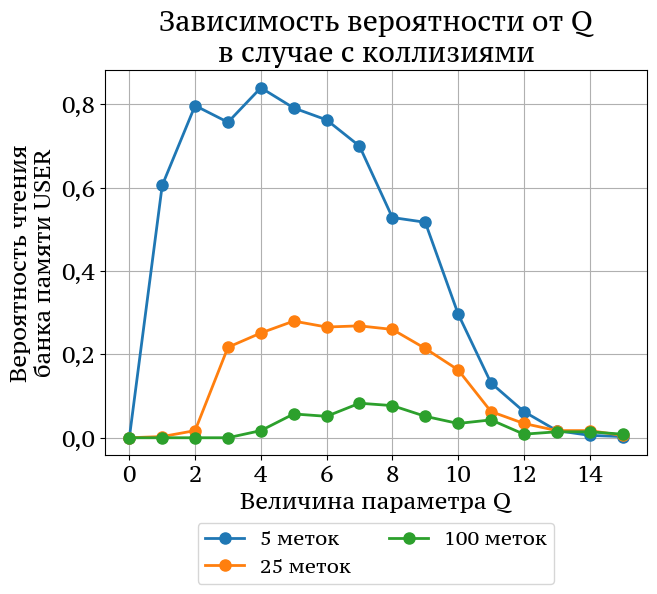

In [14]:
# Объединение результатов
merged_results = {}
for d in results_list:
    merged_results.update(d)

# Построение графика
plot_probs(
    results_list=[merged_results],       # один подграфик
    labels_list=labels,                # список меток для него
    titles=["Зависимость вероятности от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Collision probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

Старая верссия

### 💾 Получение результатов

In [15]:
# q_result = calculate_probs(
#     variable="q",
#     variable_values=q_variable,
#     params_list=q_params_list,
#     key_fn=key_name,
#     additional_params = additional_params,
#     use_json=False,
#     save_results=False,
#     json_directory=JSON_DIRECTORY,
#     file_name="q_collision.json"
# )
# Моделирование на M3 Pro с 'num_tags': 200:
# Моделирование по переменной q: 100%|██████████| 5/5 [02:11<00:00, 26.29s/it]

In [16]:
# plot_probs(
#     results_list=[q_result],
#     labels_list=[key_name(params) for params in coding_params],
#     titles=["Зависимость вероятности от Q\nв случае с коллизиями"],
#     x_variable=q_variable,
#     x_label="Величина параметра Q",
#     image_name="Collision probs",
#     save_fig=False,
#     image_directory=IMG_DIRECTORY,
#     integer_labels=True
# )